Install required libaries.

In [ ]:
# install required libraries
!pip install sdv # install the synthetic data vault library

In [ ]:
!pip install pycaret

Import required libraries.

In [ ]:
# import data science libraries
import pandas as pd
import numpy as np
import math

# import scikit-learn preprocessing
from sklearn.preprocessing import LabelEncoder, QuantileTransformer

# import pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import synthetic data vault libraries
from sdv.metadata import SingleTableMetadata
import sdv.evaluation.single_table as sdv_st

# import utility libraries
from tqdm import tqdm
import xlrd
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime

# import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

Init and set experiment parameters.

In [ ]:
# set random seed
seed = 1234

# set dimension of categorical embeddings
cat_emb_dim = 2

# set number of neurons per layer
mlp_layers = [1024, 1024, 1024, 1024]

# set non-linear activation function
activation = 'lrelu'

# set number of diffusion steps
diffusion_steps = 500

# set diffusion start and end betas
diffusion_beta_start = 1e-4
diffusion_beta_end = 0.02

# set diffusion scheduler
scheduler = 'linear'

# set number of training epochs
epochs = 500

# set training batch size
batch_size = 512

# set training learning rate
learning_rate = 1e-4

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu").type

Set random seed values.

In [ ]:
# set numpy seed
np.random.seed(seed)

# set pytorch seed
torch.manual_seed(seed)

# set cuda seed
torch.cuda.manual_seed(seed)

## Load, pre-process, and init the UCU Credit Card dataset
The dataset is available under https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.

In [ ]:
# set data path
data_url = 'https://archive.ics.uci.edu/static/public/519/heart+failure+clinical+records.zip'

# download the file
response = requests.get(data_url)

# determine the zip file
zip_file = ZipFile(BytesIO(response.content))

# extract the zip file
zip_file.extractall('data')

# read the UCI credit card dataset
train_raw = pd.read_csv('data/heart_failure_clinical_records_dataset.csv',header=0)

Inspect the top 10 rows and attribute names of the dataset retreived.

In [ ]:
# display top 10 rows
train_raw.head(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


In [ ]:
# Rename a single column
train_raw.rename(columns={'DEATH_EVENT': 'DEATHEVENT'}, inplace=True)

In [ ]:
# display attribute names
train_raw.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATHEVENT'],
      dtype='object')

Set numerical and categorical dataset attributes.

In [ ]:
# determine categorical attributes
cat_attrs = ['anaemia', 'diabetes', 'highbloodpressure', 'sex',	'smoking']

# determine numerical attributes
num_attrs = ['age', 'creatininephosphokinase', 'ejectionfraction', 'platelets', 'serumcreatinine', 'serumsodium', 'time']

Pre-process dataset attributes.

In [ ]:
# remove underscore in column names for correct inverse decoding
train_raw.columns = [col.replace('_', '') for col in train_raw.columns]

# convert categorical attributes to string
train_raw[cat_attrs] = train_raw[cat_attrs].astype(str)

# iterate over categorical attributes
for cat_attr in cat_attrs:

    # add col name to every categorical entry to make them distinguishable for embedding
    train_raw[cat_attr] = cat_attr + '_' + train_raw[cat_attr].astype('str')

Set dataset label.

In [ ]:
# extract label
label = train_raw['DEATHEVENT']

Determine the training data.

In [ ]:
# merge selected categorical and numerical attributes
train = train_raw[[*cat_attrs, *num_attrs]]

In [ ]:
train

,anaemia,diabetes,highbloodpressure,sex,smoking,age,creatininephosphokinase,ejectionfraction,platelets,serumcreatinine,serumsodium,time
0,anaemia_0,diabetes_0,highbloodpressure_1,sex_1,smoking_0,75.0,582,20,265000.00,1.9,130,4
1,anaemia_0,diabetes_0,highbloodpressure_0,sex_1,smoking_0,55.0,7861,38,263358.03,1.1,136,6
2,anaemia_0,diabetes_0,highbloodpressure_0,sex_1,smoking_1,65.0,146,20,162000.00,1.3,129,7
3,anaemia_1,diabetes_0,highbloodpressure_0,sex_1,smoking_0,50.0,111,20,210000.00,1.9,137,7
4,anaemia_1,diabetes_1,highbloodpressure_0,sex_0,smoking_0,65.0,160,20,327000.00,2.7,116,8
...,...,...,...,...,...,...,...,...,...,...,...,...
294,anaemia_0,diabetes_1,highbloodpressure_1,sex_1,smoking_1,62.0,61,38,155000.00,1.1,143,270
295,anaemia_0,diabetes_0,highbloodpressure_0,sex_0,smoking_0,55.0,1820,38,270000.00,1.2,139,271
296,anaemia_0,diabetes_1,highbloodpressure_0,sex_0,smoking_0,45.0,2060,60,742000.00,0.8,138,278
297,anaemia_0,diabetes_0,highbloodpressure_0,sex_1,smoking_1,45.0,2413,38,140000.00,1.4,140,280


Transform the numerical attributes.

In [ ]:
# init the quantile transformation
num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)

# fit transformation to numerical attributes
num_scaler.fit(train[num_attrs])

# transform numerical attributes
train_num_scaled = num_scaler.transform(train[num_attrs])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:2762: UserWarning: n_quantiles (1000) is greater than the total number of samples (299). n_quantiles is set to n_samples.
  warnings.warn(


Transform the categorical attributes.

In [ ]:
# get vocabulary of categorical attributes
vocabulary_classes = np.unique(train[cat_attrs])

# init categorical attribute encoder
label_encoder = LabelEncoder()

# fit encoder to categorical attributes
label_encoder.fit(vocabulary_classes)

# transform categorical attributes
train_cat_scaled = train[cat_attrs].apply(label_encoder.transform)

# collect unique values of each categorical attribute
vocab_per_attr = {cat_attr: set(train_cat_scaled[cat_attr]) for cat_attr in cat_attrs}

Convert numerical and categorical attributes as well as the labels to tensors.

In [ ]:
# convert numerical attributes
train_num_torch = torch.FloatTensor(train_num_scaled)

# convert categorical attributes
train_cat_torch = torch.LongTensor(train_cat_scaled.values)

# convert label
label_torch = torch.LongTensor(label)

Convert dataset to tensor dataset.

In [ ]:
# init tensor dataset
train_set = TensorDataset(
    train_cat_torch, # categorical attributes
    train_num_torch, # numerical attributes
    label_torch # dataset labels
)

Init the data loader.

In [ ]:
# init the data loader
dataloader = DataLoader(
    dataset=train_set, # training dataset
    batch_size=batch_size, # training batch size
    num_workers=0, # number of workers
    shuffle=True # shuffle training data
)

## Implement the FinDiff model

Implement the FinDiff backbone model.

In [ ]:
# define base feedforward network
class BaseNetwork(nn.Module):

    # define base network constructor
    def __init__(self, hidden_size, activation='lrelu'):

        # call super calass constructor
        super(BaseNetwork, self).__init__()

        # init
        self.layers = self.init_layers(hidden_size)

        # case: lrelu activation
        if activation == 'lrelu':

            # set lrelu activation
            self.activation = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # case: relu activation
        elif activation == 'relu':

            # set relu activation
            self.activation = nn.ReLU(inplace=True)

        # case: tanh activation
        elif activation == 'tanh':

            # set tanh activation
            self.activation = nn.Tanh()

        # case: sigmoid activation
        else:

            # set sigmoid activation
            self.activation = nn.Sigmoid()

    # define layer initialization
    def init_layers(self, layer_dimensions):

        # init layers
        layers = []

        # iterate over layer dimensions
        for i in range(len(layer_dimensions)-1):

            # init linear layer
            layer = nn.Linear(layer_dimensions[i], layer_dimensions[i + 1], bias=True)

            # init linear layer weights
            nn.init.xavier_uniform_(layer.weight)

            # init linear layer bias
            nn.init.constant_(layer.bias, 0.0)

            # collecet linear layer
            layers.append(layer)

            # register linear layer parameters
            self.add_module('linear_' + str(i), layer)

        # return layers
        return layers

    # define forward pass
    def forward(self, x):

        # iterate over layers
        for i in range(len(self.layers)):

            # run layer forward pass
            x = self.activation(self.layers[i](x))

        # return forward pass result
        return x

Implement the FinDiff model synthesizer.

In [ ]:
# define MLP synthesizer network
class MLPSynthesizer(nn.Module):

    # define MLP synthesizer network constructor
    def __init__(
            self,
            d_in: int,
            hidden_layers: list,
            activation: str='lrelu', # layer activation
            dim_t: int=64,
            n_cat_tokens=None, # number of categorical tokens
            n_cat_emb=None, # number of categorical dimensions
            embedding=None,
            embedding_learned=True,
            n_classes=None
        ):

        # call super class constructor
        super(MLPSynthesizer, self).__init__()

        # init ???
        self.dim_t = dim_t

        # init synthesizer base feed forward network
        self.backbone = BaseNetwork([dim_t, *hidden_layers], activation=activation)

        # case: categorical embedding defined
        if embedding is not None:

            # init pretrained embedding layer
            self.cat_embedding = nn.Embedding.from_pretrained(embeddings=embedding)

        # case: categorical embedding undefined
        else:

            # init new categorical embedding layer
            self.cat_embedding = nn.Embedding(n_cat_tokens, n_cat_emb, max_norm=None, scale_grad_by_freq=False)

            # activate categorical embedding layer learning
            self.cat_embedding.weight.requires_grad = embedding_learned

        # case: data classes available
        if n_classes is not None:

            # init label embedding layer
            self.label_embedding = nn.Embedding(n_classes, dim_t)

        # define input data projection
        self.projection = nn.Sequential(
            nn.Linear(d_in, dim_t), # linear layer
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer
        )

        # define time embedding projection
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t), # linear layer
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer
        )

        # define output data projection
        self.head = nn.Linear(hidden_layers[-1], d_in)

    # define sinusodial time step embedding
    def embed_time(self, timesteps, dim_out, max_period=10000):

        # half output dimension
        half_dim_out = dim_out // 2

        # determine tensor of frequencies
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half_dim_out, dtype=torch.float32) / half_dim_out)

        # push to compute device
        freqs = freqs.to(device=timesteps.device)

        # create timestep vs. frequency grid
        args = timesteps[:, None].float() * freqs[None]

        # creating the time embedding
        time_embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

        # case: odd output dimension
        if dim_out % 2:

            # append additional dimension
            time_embedding = torch.cat([time_embedding, torch.zeros_like(time_embedding[:, :1])], dim=-1)

        # return timestep embedding
        return time_embedding

    # get categorical embeddings
    def get_embeddings(self):

        # return categorical embeddings
        return self.cat_embedding.weight.data

    # perform categorical embedding
    def embed_categorical(self, x_cat):

        # perform categorical embedding
        x_cat_emb = self.cat_embedding(x_cat)

        # reshape embedding to original input
        x_cat_emb = x_cat_emb.view(-1, x_cat_emb.shape[1] * x_cat_emb.shape[2])

        # return categorical embedding
        return x_cat_emb

    # define forward pass
    def forward(self, x, timesteps, label=None):

        # init time embeddings
        time_emb = self.embed_time(timesteps, self.dim_t)

        # embedd time embeddings
        time_emb  = self.time_embed(time_emb )

        # case: data classes available
        if label is not None:

            # determine label embeddings
            time_label_emb = time_emb  + self.label_embedding(label)

        # run initial projection layer
        x = self.projection(x)

        # add time and label embedding
        x = x + time_label_emb

        # run backbone forward pass
        x =  self.backbone(x)

        # run projection forward pass
        x = self.head(x)

        # return forward pass result
        return x

Implement the FinDiff model base diffuser.

In [ ]:
# define BaseDiffuser network
class BaseDiffuser(object):

    # define base diffuser network constructor
    def __init__(
            self,
            total_steps=1000,
            beta_start=1e-4,
            beta_end=0.02,
            device='cpu',
            scheduler='linear'
        ):

        # set diffusion steps
        self.total_steps = total_steps

        # set diffusion start beta
        self.beta_start = beta_start

        # set diffusion end beta
        self.beta_end = beta_end

        # set compute device
        self.device = device

        # set noise schedule alphas and betas
        self.alphas, self.betas = self.prepare_noise_schedule(scheduler=scheduler)

        # set noise schedule alhpa hats
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    # define noise schedule
    def prepare_noise_schedule(self, scheduler: str):

        # determine noise scheduler scale
        scale = 1000 / self.total_steps

        # scale beta start
        beta_start = scale * self.beta_start

        # scale beta end
        beta_end = scale * self.beta_end

        # case: linear noise scheduler
        if scheduler == 'linear':

            # determine linear noise schedule betas
            betas = torch.linspace(beta_start, beta_end, self.total_steps)

            # determine linear noise schedule alphas
            alphas = 1.0 - betas

        # case: quadratic noise scheduler
        elif scheduler == 'quad':

            # determine quadratic noise schedule betas
            betas = torch.linspace(self.beta_start ** 0.5, self.beta_end ** 0.5, self.total_steps) ** 2

            # determine quadratic noise schedule alphas
            alphas = 1.0 - betas

        # return noise scheduler alphas and betas
        return alphas.to(self.device), betas.to(self.device)

    # define random timesteps sampler
    def sample_random_timesteps(self, n: int):

        # sample random timesteps
        t = torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

        # return random timesteps
        return t

    # define gaussian noise addition
    def add_gauss_noise(self, x_num, t):

        # determine noise alpha hat
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None]

        # determine noise one minius alpha hat
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None]

        # determine numeric noise
        noise_num = torch.randn_like(x_num)

        # determine x numeric noise
        x_noise_num = sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num

        # return x numeric noise and numeric noise
        return x_noise_num, noise_num

    # define gaussian noise sampling
    def p_sample_gauss(self, model_out, z_norm, timesteps):

        # determine noise alpha hat
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None]

        # determine noise betas
        betas_t = self.betas[timesteps][:, None]

        # determine noise one minius alpha hat
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None]

        epsilon_t = torch.sqrt(self.betas[timesteps][:, None])

        # determine random noise
        random_noise = torch.randn_like(z_norm)
        random_noise[timesteps == 0] = 0.0

        # determine model mean
        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))

        # determine z norm
        z_norm = model_mean + (epsilon_t * random_noise)

        # return z norm
        return z_norm

## Initialize and train the FinDiff model

In [ ]:
# determine number unique categorical tokens
n_cat_tokens = len(np.unique(train[cat_attrs]))

# determine total categorical embedding dimension
cat_dim = cat_emb_dim * len(cat_attrs)

# determine total numerical embedding dimension
num_dim = len(num_attrs)

# determine total embedding dimension
encoded_dim = cat_dim + num_dim

In [ ]:
# initialize the FinDiff synthesizer model
synthesizer_model = MLPSynthesizer(
    d_in=encoded_dim,
    hidden_layers=mlp_layers,
    activation=activation,
    n_cat_tokens=n_cat_tokens,
    n_cat_emb=cat_emb_dim,
    n_classes=pd.Series(label).nunique(),
    embedding_learned=False
)

In [ ]:
# initialize the FinDiff base diffuser model
diffuser_model = BaseDiffuser(
    total_steps=diffusion_steps,
    beta_start=diffusion_beta_start,
    beta_end=diffusion_beta_end,
    scheduler=scheduler,
    device=device
)

Init optimizer, scheduler and loss function.

In [ ]:
# determine synthesizer model parameters
parameters = filter(lambda p: p.requires_grad, synthesizer_model.parameters())

# init Adam optimizer
optimizer = optim.Adam(parameters, lr=learning_rate)

# init learning rate scheduler
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=False)

# int mean-squared-error loss
loss_fnc = nn.MSELoss()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
synthesizer_model.train()

# move to the device
synthesizer_model = synthesizer_model.to(device)

# init the training progress bar
pbar = tqdm(iterable=range(epochs), position=0, leave=True)

# iterate over training epochs
for epoch in pbar:

    base_params = {'epoch': epoch, 'seed': seed, 'mlp_layers': mlp_layers}

    # init epoch training batch losses
    batch_losses = []

    # iterate over epoch batches
    for batch_cat, batch_num, batch_y in dataloader:

        # move tensors to device
        batch_cat = batch_cat.to(device)
        batch_num = batch_num.to(device)
        batch_y = batch_y.to(device)

        # sample diffusion timestep
        timesteps = diffuser_model.sample_random_timesteps(n=batch_cat.shape[0])

        # determine categorical embeddings
        batch_cat_emb = synthesizer_model.embed_categorical(x_cat=batch_cat)

        # concatenate categorical and numerical embeddings
        batch_cat_num = torch.cat((batch_cat_emb, batch_num), dim=1)

        # add diffuser gaussian noise
        batch_noise_t, noise_t = diffuser_model.add_gauss_noise(x_num=batch_cat_num, t=timesteps)

        # conduct synthesizer model forward pass
        predicted_noise = synthesizer_model(x=batch_noise_t, timesteps=timesteps, label=batch_y)

        # compute training batch loss
        batch_loss = loss_fnc(input=noise_t, target=predicted_noise)

        # reset model gradients
        optimizer.zero_grad()

        # run model backward pass
        batch_loss.backward()

        # optimize model parameters
        optimizer.step()

        # collect training batch losses
        batch_losses.append(batch_loss.detach().cpu().numpy())

    # determine mean training epoch loss
    batch_losses_mean = np.mean(np.array(batch_losses))

    # update learning rate scheduler
    lr_scheduler.step()

    # collect mean training epoch loss
    train_epoch_losses.append(batch_losses_mean)

    # prepare and set training epoch progress bar update
    now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    pbar.set_description('[LOG {}] epoch: {}, train-loss: {}'.format(str(now), str(epoch).zfill(4), str(batch_losses_mean)))


[LOG 2025-01-30 19:00:28] epoch: 0499, train-loss: 0.3268049: 100%|██████████| 500/500 [01:34<00:00,  5.32it/s]


Visualize training loss progression.

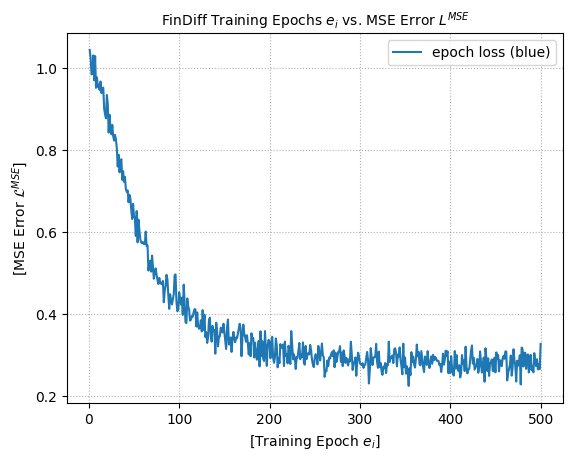

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel('[Training Epoch $e_i$]', fontsize=10)
ax.set_ylabel('[MSE Error $\mathcal{L}^{MSE}$]', fontsize=10)

# set plot legend
plt.legend(loc='upper right', numpoints=1, fancybox=True)

# add plot title
plt.title('FinDiff Training Epochs $e_i$ vs. MSE Error $L^{MSE}$', fontsize=10);

## Generate Data using the FinDiff model

Init and set sampling parameters.

Use FinDiff to generate new data samples.

In [ ]:
# init samples to be generated
samples = torch.randn((len(label_torch), encoded_dim), device=device)

# init the generation progress bar
pbar = tqdm(iterable=reversed(range(0, diffusion_steps)), position=0, leave=True)

with torch.no_grad():
  # iterate over diffusion steps
  for diffusion_step in pbar:

      # prepare and set training epoch progress bar update
      now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
      pbar.set_description('[LOG {}] Diffusion Step: {}'.format(str(now), str(diffusion_step).zfill(4)))

      # init diffusion timesteps
      timesteps = torch.full((len(label_torch),), diffusion_step, dtype=torch.long, device=device)

      # run synthesizer model forward pass
      model_out = synthesizer_model(x=samples.float(), timesteps=timesteps, label=label_torch.to(device))

      # run diffuser model forward pass
      samples = diffuser_model.p_sample_gauss(model_out, samples, timesteps)


[LOG 2025-01-30 19:00:56] Diffusion Step: 0000: : 500it [00:27, 17.96it/s]


In [ ]:
len(label_torch)

299

Decode generated FinDiff samples.

In [ ]:
# split sample into numeric and categorical parts
samples = samples.detach().cpu().numpy()
samples_num = samples[:, cat_dim:]
samples_cat = samples[:, :cat_dim]

# denormalize numeric attributes
z_norm_upscaled = num_scaler.inverse_transform(samples_num)
z_norm_df = pd.DataFrame(z_norm_upscaled, columns=num_attrs)

# get embedding lookup matrix
embedding_lookup = synthesizer_model.get_embeddings().cpu()

# reshape back to batch_size * n_dim_cat * cat_emb_dim
samples_cat = samples_cat.reshape(-1, len(cat_attrs), cat_emb_dim)

# compute pairwise distances
distances = torch.cdist(x1=embedding_lookup, x2=torch.Tensor(samples_cat))

# get the closest distance based on the embeddings that belong to a column category
z_cat_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

nearest_dist_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

# iterate over categorical attributes
for attr_idx, attr_name in enumerate(cat_attrs):

    attr_emb_idx = list(vocab_per_attr[attr_name])
    attr_distances = distances[:, attr_emb_idx, attr_idx]

    nearest_values, nearest_idx = torch.min(attr_distances, dim=1)
    nearest_idx = nearest_idx.cpu().numpy()

    z_cat_df[attr_name] = np.array(attr_emb_idx)[nearest_idx]  # need to map emb indices back to column indices
    nearest_dist_df[attr_name] = nearest_values.cpu().numpy()

z_cat_df = z_cat_df.apply(label_encoder.inverse_transform)

samples_decoded = pd.concat([z_cat_df, z_norm_df], axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd

# Assuming df is your DataFrame
samples_decoded.to_csv('data/samples.csv', index=False)

In [ ]:
samples_decoded.head(10)

,anaemia,diabetes,highbloodpressure,sex,smoking,age,creatininephosphokinase,ejectionfraction,platelets,serumcreatinine,serumsodium,time
0,anaemia_0,diabetes_1,highbloodpressure_0,sex_1,smoking_1,42.000000,55.188164,14.286907,541228.062500,1.200000,137.0,67.301788
1,anaemia_1,diabetes_0,highbloodpressure_0,sex_0,smoking_1,55.000000,208.527710,14.004066,50374.824219,9.292393,134.0,10.000000
2,anaemia_0,diabetes_0,highbloodpressure_0,sex_1,smoking_1,81.434807,64.000000,30.000000,211261.734375,6.079862,130.0,174.000000
3,anaemia_0,diabetes_0,highbloodpressure_0,sex_1,smoking_0,42.000000,87.714989,25.000000,173684.015625,1.000000,136.0,90.000000
4,anaemia_0,diabetes_0,highbloodpressure_0,sex_0,smoking_1,95.000000,7734.559570,14.655079,850000.000000,1.180000,113.0,120.827980
5,anaemia_1,diabetes_0,highbloodpressure_0,sex_1,smoking_1,40.000000,7806.276855,14.000153,365000.000000,0.500865,136.0,10.603201
6,anaemia_1,diabetes_0,highbloodpressure_1,sex_1,smoking_1,50.000000,54.886490,25.000000,149000.000000,1.000000,135.0,48.174789
7,anaemia_1,diabetes_0,highbloodpressure_0,sex_0,smoking_1,73.000000,128.636353,14.091620,506175.125000,1.436511,145.0,112.000000
8,anaemia_0,diabetes_0,highbloodpressure_1,sex_1,smoking_1,45.000000,145.822006,30.000000,259447.984375,1.472644,134.0,37.667648
9,anaemia_0,diabetes_0,highbloodpressure_1,sex_1,smoking_1,68.539772,2681.582764,30.000000,236332.937500,2.422451,132.0,106.513504


## Evaluate the Generated Data

In [ ]:
# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train)

# generate quality report
quality_report = sdv_st.evaluate_quality(
    real_data=train,
    synthetic_data=samples_decoded,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 364.66it/s]|
Column Shapes Score: 85.67%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 77.37it/s]|
Column Pair Trends Score: 82.62%

Overall Score (Average): 84.15%



In [ ]:
# plot Column Shapes -> referred to the "Fidelity Column" in the paper
fig = quality_report.get_visualization(property_name='Column Shapes')
fig.show()

In [ ]:
# plot Column Pair Trends -> referred to the "Fidelity Row" in the paper
fig = quality_report.get_visualization(property_name='Column Pair Trends')
fig.show()

In [ ]:
samples_decoded['DEATHEVENT'] = label_torch.cpu().numpy()


In [ ]:
samples_decoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   anaemia                  299 non-null    object 
 1   diabetes                 299 non-null    object 
 2   highbloodpressure        299 non-null    object 
 3   sex                      299 non-null    object 
 4   smoking                  299 non-null    object 
 5   age                      299 non-null    float32
 6   creatininephosphokinase  299 non-null    float32
 7   ejectionfraction         299 non-null    float32
 8   platelets                299 non-null    float32
 9   serumcreatinine          299 non-null    float32
 10  serumsodium              299 non-null    float32
 11  time                     299 non-null    float32
 12  DEATHEVENT               299 non-null    int64  
dtypes: float32(7), int64(1), object(5)
memory usage: 22.3+ KB


In [ ]:
samples_decoded['DEATHEVENT'].value_counts()

,count
DEATHEVENT,
0,203
1,96


In [ ]:
df_synthetic = samples_decoded.copy()

In [ ]:
df_real = train_raw.copy()

In [ ]:
from pycaret.classification import *
s = setup(data=df_synthetic, target = 'DEATHEVENT', test_data=df_real, index=False, session_id = 123)

,Description,Value
0,Session id,123
1,Target,DEATHEVENT
2,Target type,Binary
3,Original data shape,"(598, 13)"
4,Transformed data shape,"(598, 13)"
5,Transformed train set shape,"(299, 13)"
6,Transformed test set shape,"(299, 13)"
7,Numeric features,7
8,Categorical features,5
9,Preprocess,True


In [ ]:
# functional API
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8462,0.9098,0.6778,0.8334,0.7341,0.6292,0.6464,0.6260
rf,Random Forest Classifier,0.8360,0.9110,0.6867,0.7872,0.7223,0.6085,0.6197,0.3500
gbc,Gradient Boosting Classifier,0.8297,0.8973,0.6889,0.7815,0.7209,0.6005,0.6130,0.2030
xgboost,Extreme Gradient Boosting,0.8230,0.8933,0.6778,0.7650,0.7090,0.5835,0.5942,0.1330
et,Extra Trees Classifier,0.8224,0.8933,0.5711,0.8279,0.6539,0.5470,0.5749,0.2130
ada,Ada Boost Classifier,0.8093,0.8569,0.6467,0.7358,0.6800,0.5463,0.5554,0.1870
lr,Logistic Regression,0.8091,0.8705,0.6456,0.7312,0.6797,0.5457,0.5522,1.4760
ridge,Ridge Classifier,0.7991,0.8735,0.5733,0.7492,0.6405,0.5068,0.5211,0.0790
lda,Linear Discriminant Analysis,0.7991,0.8735,0.5944,0.7288,0.6474,0.5116,0.5210,0.0820
qda,Quadratic Discriminant Analysis,0.7825,0.8373,0.5122,0.7262,0.5909,0.4537,0.4708,0.1470


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
from pycaret.classification import *
s_real = setup(df_real, target = 'DEATHEVENT', session_id = 1234)

,Description,Value
0,Session id,1234
1,Target,DEATHEVENT
2,Target type,Binary
3,Original data shape,"(299, 13)"
4,Transformed data shape,"(299, 13)"
5,Transformed train set shape,"(209, 13)"
6,Transformed test set shape,"(90, 13)"
7,Numeric features,7
8,Categorical features,5
9,Preprocess,True


In [ ]:
# functional API
best_real = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8707,0.9055,0.7429,0.8275,0.7754,0.6865,0.6944,0.3040
lightgbm,Light Gradient Boosting Machine,0.8467,0.8803,0.7429,0.7712,0.7504,0.6405,0.6458,0.2670
gbc,Gradient Boosting Classifier,0.8379,0.8677,0.7143,0.7662,0.7348,0.6187,0.6233,0.1810
xgboost,Extreme Gradient Boosting,0.8371,0.8779,0.7429,0.7499,0.7396,0.6216,0.6274,0.1910
lda,Linear Discriminant Analysis,0.8086,0.8387,0.6548,0.7393,0.6822,0.5468,0.5581,0.0800
lr,Logistic Regression,0.8038,0.8448,0.6548,0.7238,0.6768,0.5372,0.5471,0.1950
ridge,Ridge Classifier,0.8038,0.8387,0.6405,0.7345,0.6723,0.5341,0.5457,0.1400
ada,Ada Boost Classifier,0.7755,0.8217,0.6119,0.6590,0.6321,0.4717,0.4740,0.1650
et,Extra Trees Classifier,0.7700,0.8369,0.4881,0.6850,0.5657,0.4180,0.4310,0.2700
nb,Naive Bayes,0.7657,0.8211,0.4643,0.7033,0.5566,0.4077,0.4244,0.0800


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
evaluate_model(best_real)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
clf_setup = setup(
    data=df_real,
    target='DEATHEVENT',
    fix_imbalance=True,
    session_id=42,

)

,Description,Value
0,Session id,42
1,Target,DEATHEVENT
2,Target type,Binary
3,Original data shape,"(299, 13)"
4,Transformed data shape,"(374, 13)"
5,Transformed train set shape,"(284, 13)"
6,Transformed test set shape,"(90, 13)"
7,Numeric features,7
8,Categorical features,5
9,Preprocess,True


In [ ]:
best_model_smote = compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8426,0.8971,0.7619,0.7544,0.7512,0.6367,0.6438,0.2540
lr,Logistic Regression,0.8329,0.8708,0.7810,0.7394,0.7489,0.6252,0.6364,0.5310
lightgbm,Light Gradient Boosting Machine,0.8283,0.8965,0.7810,0.7478,0.7456,0.6204,0.6377,0.3160
gbc,Gradient Boosting Classifier,0.8186,0.8806,0.7619,0.6990,0.7230,0.5893,0.5963,0.3520
et,Extra Trees Classifier,0.8186,0.8901,0.6167,0.7808,0.6769,0.5568,0.5715,0.2130
xgboost,Extreme Gradient Boosting,0.8138,0.8940,0.7167,0.7224,0.7117,0.5755,0.5831,0.1280
nb,Naive Bayes,0.8090,0.8499,0.7190,0.7331,0.7102,0.5701,0.5840,0.0860
ada,Ada Boost Classifier,0.7850,0.8636,0.6690,0.6582,0.6575,0.5016,0.5060,0.2850
lda,Linear Discriminant Analysis,0.7805,0.8647,0.7667,0.6478,0.6930,0.5254,0.5393,0.0880
ridge,Ridge Classifier,0.7757,0.8647,0.7667,0.6383,0.6878,0.5165,0.5307,0.0850


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
evaluate_model(best_model_smote)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…